# Importing Necessary Libraries

In [100]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from cryptography.fernet import Fernet
import matplotlib.pyplot as plt
import time


# Loading and Preprocessing Datasets



In [101]:
# Load datasets
embb_data = pd.read_csv('eMBB.csv')
mmtc_data = pd.read_csv('mMTC.csv')
urllc_data = pd.read_csv('URLLC.csv')

# Handle missing values and encode features
def preprocess_dataset(data):
    numeric_data = data.select_dtypes(include=[np.number])
    numeric_data.fillna(numeric_data.mean(), inplace=True)
    non_numeric_data = data.select_dtypes(exclude=[np.number])
    if not non_numeric_data.empty:
        numeric_data = pd.concat(
            [numeric_data, pd.get_dummies(non_numeric_data, drop_first=True)], axis=1
        )
    return numeric_data

# Preprocess all datasets
embb_data = preprocess_dataset(embb_data)
mmtc_data = preprocess_dataset(mmtc_data)
urllc_data = preprocess_dataset(urllc_data)
    

# Dropping Unnecessary Columns With High NaN Values from eMBB and mMTC Datasets

In [102]:
embb_data = embb_data.drop(columns=['sVid', 'dVid'])
mmtc_data = mmtc_data.drop(columns=['sVid', 'dVid'])

# Scaling Features and Separating Targets


In [103]:
scaler = StandardScaler()

def preprocess(data):
    features = data.iloc[:, :-1]
    target = data.iloc[:, -1]
    features_scaled = scaler.fit_transform(features)
    return features_scaled, target

# Preprocess datasets
embb_features, embb_target = preprocess(embb_data)
mmtc_features, mmtc_target = preprocess(mmtc_data)
urllc_features, urllc_target = preprocess(urllc_data)

# Print shapes
print(f"eMBB Features Shape: {embb_features.shape}, Target Shape: {embb_target.shape}")
print(f"mMTC Features Shape: {mmtc_features.shape}, Target Shape: {mmtc_target.shape}")
print(f"URLLC Features Shape: {urllc_features.shape}, Target Shape: {urllc_target.shape}")


eMBB Features Shape: (5808, 44), Target Shape: (5808,)
mMTC Features Shape: (4615, 50), Target Shape: (4615,)
URLLC Features Shape: (4033, 69), Target Shape: (4033,)


# Splitting and Cleaning Data



In [104]:
def split_data(features, target):
    return train_test_split(features, target, test_size=0.2, random_state=42)

embb_x_train, embb_x_test, embb_y_train, embb_y_test = split_data(embb_features, embb_target)
mmtc_x_train, mmtc_x_test, mmtc_y_train, mmtc_y_test = split_data(mmtc_features, mmtc_target)
urllc_x_train, urllc_x_test, urllc_y_train, urllc_y_test = split_data(urllc_features, urllc_target)

# Function to clean the data
def clean_data(features, target):
    # Replace NaN and infinite values
    features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    target = np.nan_to_num(target, nan=0.0, posinf=0.0, neginf=0.0)
    return features, target

# Clean each dataset
embb_x_train, embb_y_train = clean_data(embb_x_train, embb_y_train)
mmtc_x_train, mmtc_y_train = clean_data(mmtc_x_train, mmtc_y_train)
urllc_x_train, urllc_y_train = clean_data(urllc_x_train, urllc_y_train)

embb_x_test, embb_y_test = clean_data(embb_x_test, embb_y_test)
mmtc_x_test, mmtc_y_test = clean_data(mmtc_x_test, mmtc_y_test)
urllc_x_test, urllc_y_test = clean_data(urllc_x_test, urllc_y_test)


# Training Random Forest Models


In [105]:
def train_model(x_train, y_train):
    model = RandomForestClassifier(random_state=42)
    model.fit(x_train, y_train)
    return model

# Train models for each slice type
embb_model = train_model(embb_x_train, embb_y_train)
mmtc_model = train_model(mmtc_x_train, mmtc_y_train)
urllc_model = train_model(urllc_x_train, urllc_y_train)


# Making Predictions

In [106]:
# Predict resource needs
def predict_resources(model, x_test):
    return model.predict(x_test)

embb_predictions = predict_resources(embb_model, embb_x_test)
mmtc_predictions = predict_resources(mmtc_model, mmtc_x_test)
urllc_predictions = predict_resources(urllc_model, urllc_x_test)


# Encrypting and Decrypting Data

eMBB - Encryption time: 0.1597 seconds
eMBB - Decryption time: 0.1404 seconds
mMTC - Encryption time: 0.1167 seconds
mMTC - Decryption time: 0.1120 seconds
URLLC - Encryption time: 0.1153 seconds
URLLC - Decryption time: 0.1025 seconds


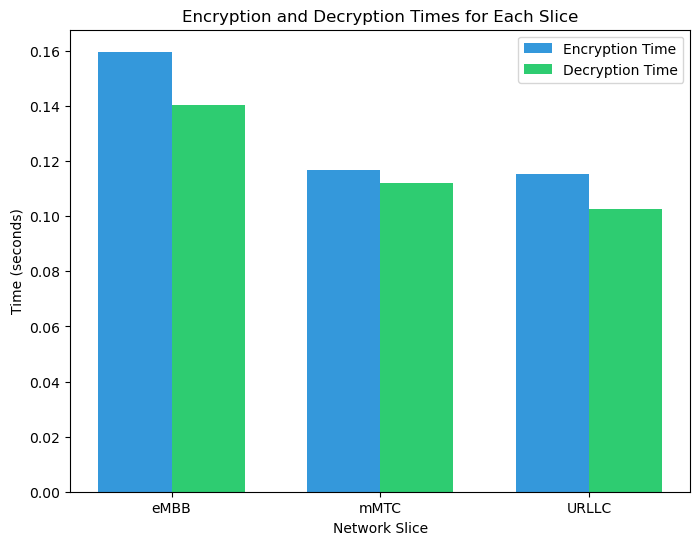

In [107]:
# Function to encrypt data
def encrypt_data(data, key):
    f = Fernet(key)
    return [f.encrypt(str(value).encode()) for value in data]

# Function to decrypt data
def decrypt_data(data, key):
    f = Fernet(key)
    return [f.decrypt(value).decode() for value in data]

# Generate a key for encryption and decryption
key = Fernet.generate_key()

# Function to measure encryption and decryption times for each slice
def measure_encryption_decryption_time(slice_name, data, key):
    start_time_encryption = time.time()
    encrypted_data = encrypt_data(data, key)
    encryption_time = time.time() - start_time_encryption

    start_time_decryption = time.time()
    decrypted_data = decrypt_data(encrypted_data, key)
    decryption_time = time.time() - start_time_decryption

    print(f"{slice_name} - Encryption time: {encryption_time:.4f} seconds")
    print(f"{slice_name} - Decryption time: {decryption_time:.4f} seconds")

    return encryption_time, decryption_time

# Example: Measure for eMBB, mMTC, and URLLC slices
embb_encryption_time, embb_decryption_time = measure_encryption_decryption_time('eMBB', embb_y_train, key)
mmtc_encryption_time, mmtc_decryption_time = measure_encryption_decryption_time('mMTC', mmtc_y_train, key)
urllc_encryption_time, urllc_decryption_time = measure_encryption_decryption_time('URLLC', urllc_y_train, key)

# Plotting the encryption and decryption times for each slice
slices = ['eMBB', 'mMTC', 'URLLC']
encryption_times = [embb_encryption_time, mmtc_encryption_time, urllc_encryption_time]
decryption_times = [embb_decryption_time, mmtc_decryption_time, urllc_decryption_time]

# Create a bar plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the bars for encryption and decryption times
bar_width = 0.35
x = range(len(slices))

ax.bar(x, encryption_times, bar_width, label='Encryption Time', color='#3498db')
ax.bar([p + bar_width for p in x], decryption_times, bar_width, label='Decryption Time', color='#2ecc71')

ax.set_xlabel('Network Slice')
ax.set_ylabel('Time (seconds)')
ax.set_title('Encryption and Decryption Times for Each Slice')
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(slices)
ax.legend()

plt.show()


# Evaluating Models



In [108]:
def evaluate_model(y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))
    print("Classification Report:\n", classification_report(y_true, y_pred))

print("eMBB Evaluation:")
evaluate_model(embb_y_test, embb_predictions)

print("\nmMTC Evaluation:")
evaluate_model(mmtc_y_test, mmtc_predictions)

print("\nURLLC Evaluation:")
evaluate_model(urllc_y_test, urllc_predictions)


eMBB Evaluation:
Accuracy: 0.995697074010327
F1 Score: 0.995696227754005
Classification Report:
               precision    recall  f1-score   support

       False       0.99      1.00      1.00       605
        True       1.00      0.99      1.00       557

    accuracy                           1.00      1162
   macro avg       1.00      1.00      1.00      1162
weighted avg       1.00      1.00      1.00      1162


mMTC Evaluation:
Accuracy: 0.9956663055254604
F1 Score: 0.9956674301580951
Classification Report:
               precision    recall  f1-score   support

       False       1.00      0.99      1.00       517
        True       0.99      1.00      1.00       406

    accuracy                           1.00       923
   macro avg       1.00      1.00      1.00       923
weighted avg       1.00      1.00      1.00       923


URLLC Evaluation:
Accuracy: 1.0
F1 Score: 1.0
Classification Report:
               precision    recall  f1-score   support

       False       1.00

# Plotting Evaluation Metrics (Before Simulating Real-World Behavior)

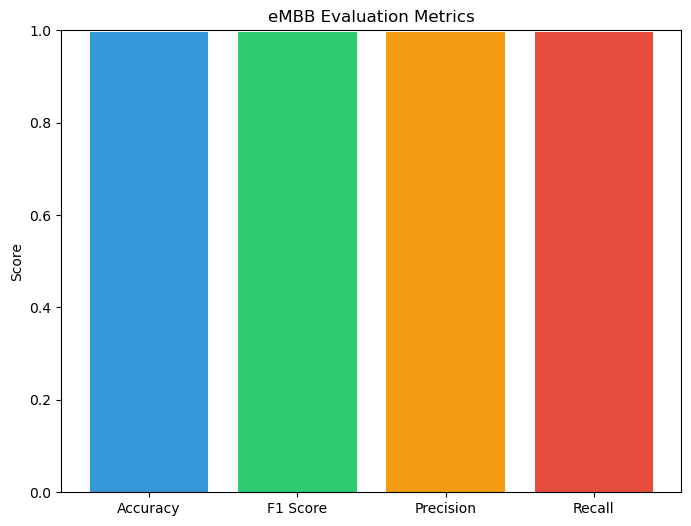

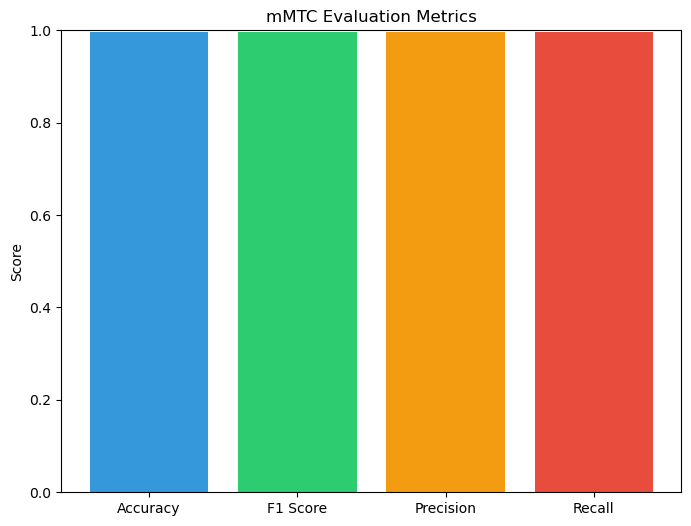

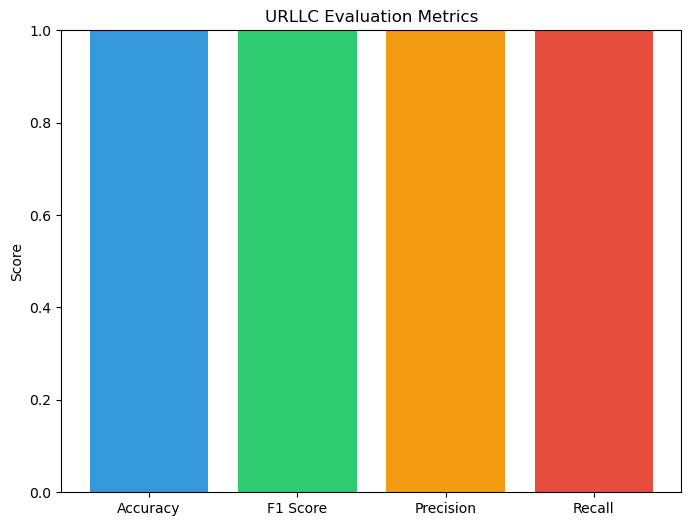

In [109]:
# Function to plot evaluation metrics
def plot_evaluation_metrics(slice_name, accuracy, f1_score, precision, recall):
    categories = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
    values = [accuracy, f1_score, precision, recall]
    
    plt.figure(figsize=(8, 6))
    plt.bar(categories, values, color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'])
    plt.title(f'{slice_name} Evaluation Metrics')
    plt.ylabel('Score')
    plt.ylim([0, 1])
    plt.show()

# eMBB Evaluation Results
eMBB_accuracy = accuracy_score(embb_y_test, embb_predictions)
eMBB_f1_score = f1_score(embb_y_test, embb_predictions, average='weighted')
eMBB_class_report = classification_report(embb_y_test, embb_predictions, output_dict=True)
eMBB_precision = eMBB_class_report['weighted avg']['precision']
eMBB_recall = eMBB_class_report['weighted avg']['recall']

# mMTC Evaluation Results
mMTC_accuracy = accuracy_score(mmtc_y_test, mmtc_predictions)
mMTC_f1_score = f1_score(mmtc_y_test, mmtc_predictions, average='weighted')
mMTC_class_report = classification_report(mmtc_y_test, mmtc_predictions, output_dict=True)
mMTC_precision = mMTC_class_report['weighted avg']['precision']
mMTC_recall = mMTC_class_report['weighted avg']['recall']

# URLLC Evaluation Results
URLLC_accuracy = accuracy_score(urllc_y_test, urllc_predictions)
URLLC_f1_score = f1_score(urllc_y_test, urllc_predictions, average='weighted')
URLLC_class_report = classification_report(urllc_y_test, urllc_predictions, output_dict=True)
URLLC_precision = URLLC_class_report['weighted avg']['precision']
URLLC_recall = URLLC_class_report['weighted avg']['recall']

# Plot evaluation results for each slice
plot_evaluation_metrics('eMBB', eMBB_accuracy, eMBB_f1_score, eMBB_precision, eMBB_recall)
plot_evaluation_metrics('mMTC', mMTC_accuracy, mMTC_f1_score, mMTC_precision, mMTC_recall)
plot_evaluation_metrics('URLLC', URLLC_accuracy, URLLC_f1_score, URLLC_precision, URLLC_recall)


# Simulating Real-World Behavior and Evaluating Models After Simulation

In [110]:
def simulate_real_world_behavior(features, variability=0.1):
    noise = np.random.normal(loc=0.0, scale=variability, size=features.shape)
    return features + noise

simulated_embb_x_test = simulate_real_world_behavior(embb_x_test, variability=0.2)
simulated_mmtc_x_test = simulate_real_world_behavior(mmtc_x_test, variability=0.15)
simulated_urllc_x_test = simulate_real_world_behavior(urllc_x_test, variability=0.05)

# Predictions on simulated data
simulated_embb_predictions = predict_resources(embb_model, simulated_embb_x_test)
simulated_mmtc_predictions = predict_resources(mmtc_model, simulated_mmtc_x_test)
simulated_urllc_predictions = predict_resources(urllc_model, simulated_urllc_x_test)

print("\nSimulated eMBB Evaluation:")
evaluate_model(embb_y_test, simulated_embb_predictions)

print("\nSimulated mMTC Evaluation:")
evaluate_model(mmtc_y_test, simulated_mmtc_predictions)

print("\nSimulated URLLC Evaluation:")
evaluate_model(urllc_y_test, simulated_urllc_predictions)



Simulated eMBB Evaluation:
Accuracy: 0.8812392426850258
F1 Score: 0.8790402499209667
Classification Report:
               precision    recall  f1-score   support

       False       0.82      1.00      0.90       605
        True       1.00      0.76      0.86       557

    accuracy                           0.88      1162
   macro avg       0.91      0.88      0.88      1162
weighted avg       0.90      0.88      0.88      1162


Simulated mMTC Evaluation:
Accuracy: 0.752979414951246
F1 Score: 0.7274991860676617
Classification Report:
               precision    recall  f1-score   support

       False       0.69      1.00      0.82       517
        True       0.99      0.44      0.61       406

    accuracy                           0.75       923
   macro avg       0.84      0.72      0.71       923
weighted avg       0.83      0.75      0.73       923


Simulated URLLC Evaluation:
Accuracy: 0.9776951672862454
F1 Score: 0.9777688450227646
Classification Report:
               pr

# Plotting Evaluation Metrics After Simulation


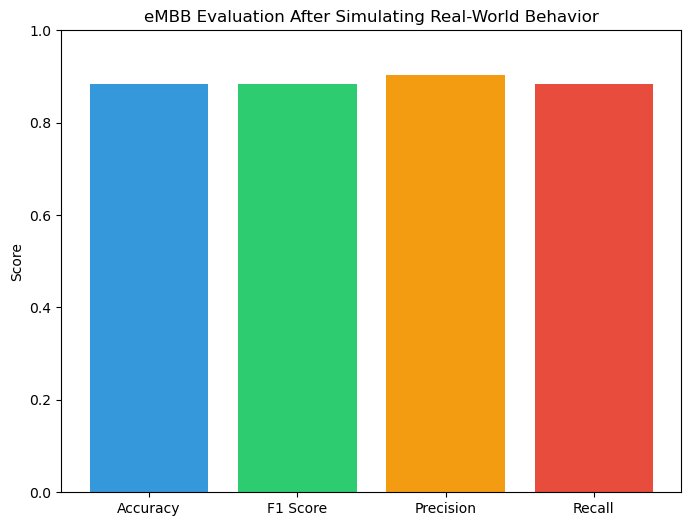

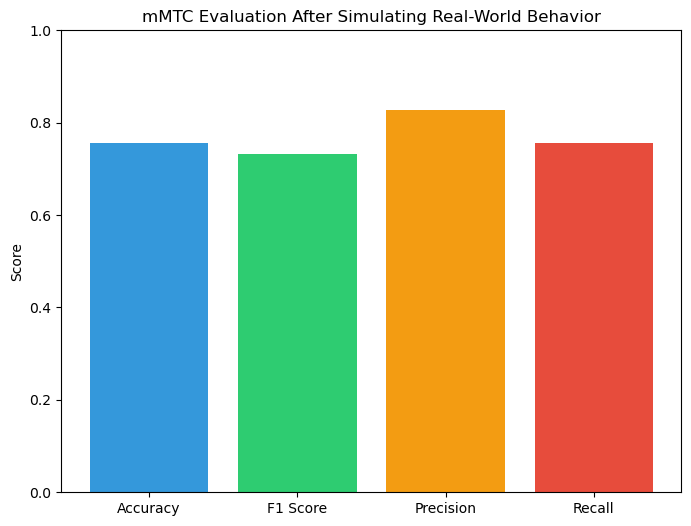

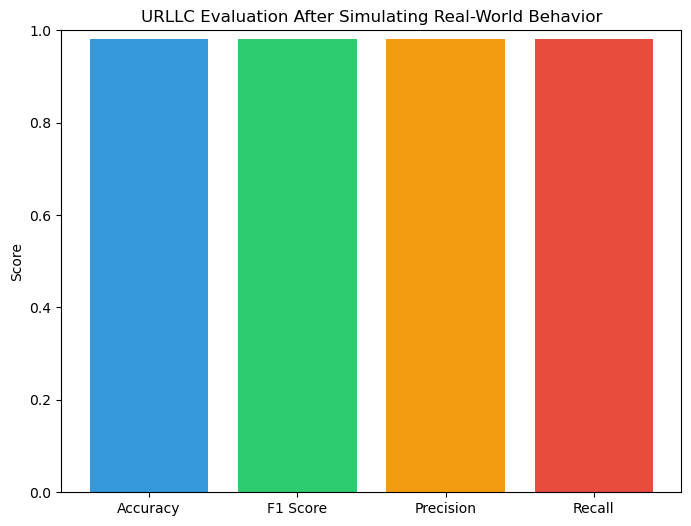

In [111]:
# Function to simulate real-world behavior by adding noise to the features
def simulate_real_world_behavior(features, variability=0.1):
    noise = np.random.normal(loc=0.0, scale=variability, size=features.shape)
    return features + noise

# Function to evaluate and visualize performance after simulating real-world behavior
def simulate_and_evaluate(model, x_test, y_test, slice_name, variability=0.1):
    # Simulate real-world behavior
    simulated_x_test = simulate_real_world_behavior(x_test, variability)
    
    # Predictions on simulated data
    simulated_predictions = model.predict(simulated_x_test)
    
    # Evaluation metrics
    accuracy = accuracy_score(y_test, simulated_predictions)
    f1 = f1_score(y_test, simulated_predictions, average='weighted')
    class_report = classification_report(y_test, simulated_predictions, output_dict=True)
    precision = class_report['weighted avg']['precision']
    recall = class_report['weighted avg']['recall']
    
    # Function to visualize evaluation results
    def plot_evaluation_results(slice_name, accuracy, f1_score, precision, recall):
        categories = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
        values = [accuracy, f1_score, precision, recall]
        
        plt.figure(figsize=(8, 6))
        plt.bar(categories, values, color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'])
        plt.title(f'{slice_name} Evaluation After Simulating Real-World Behavior')
        plt.ylabel('Score')
        plt.ylim([0, 1])
        plt.show()

    # Plot the results for this slice
    plot_evaluation_results(slice_name, accuracy, f1, precision, recall)

# Simulate and evaluate for eMBB, mMTC, and URLLC slices
simulate_and_evaluate(embb_model, embb_x_test, embb_y_test, 'eMBB', variability=0.2)
simulate_and_evaluate(mmtc_model, mmtc_x_test, mmtc_y_test, 'mMTC', variability=0.15)
simulate_and_evaluate(urllc_model, urllc_x_test, urllc_y_test, 'URLLC', variability=0.05)


# Comparing Evaluation Results Before and After Simulation

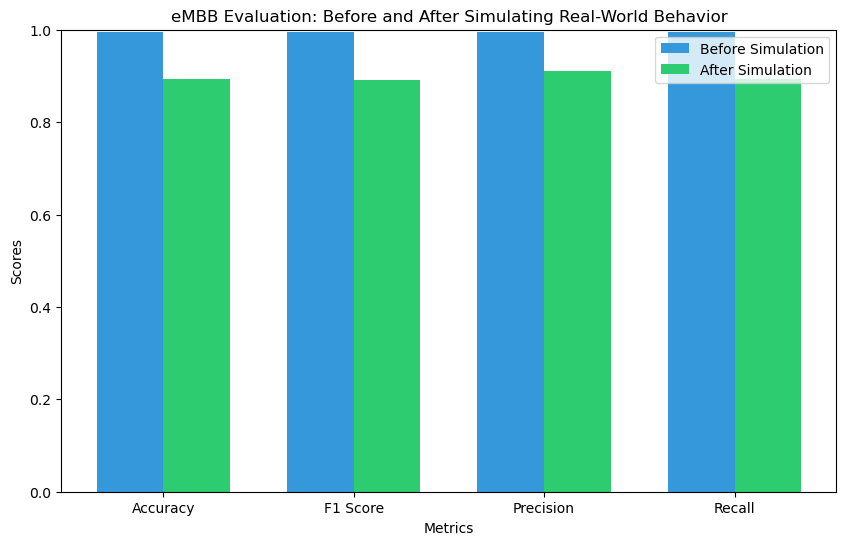

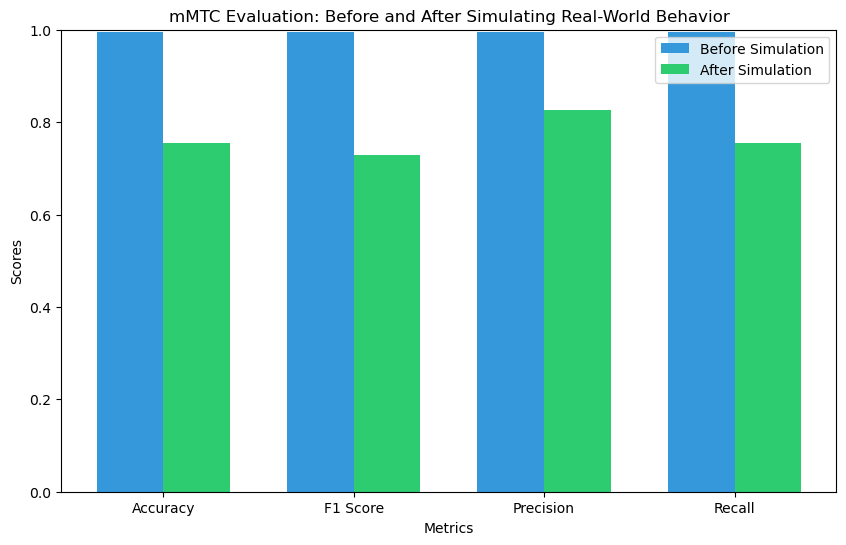

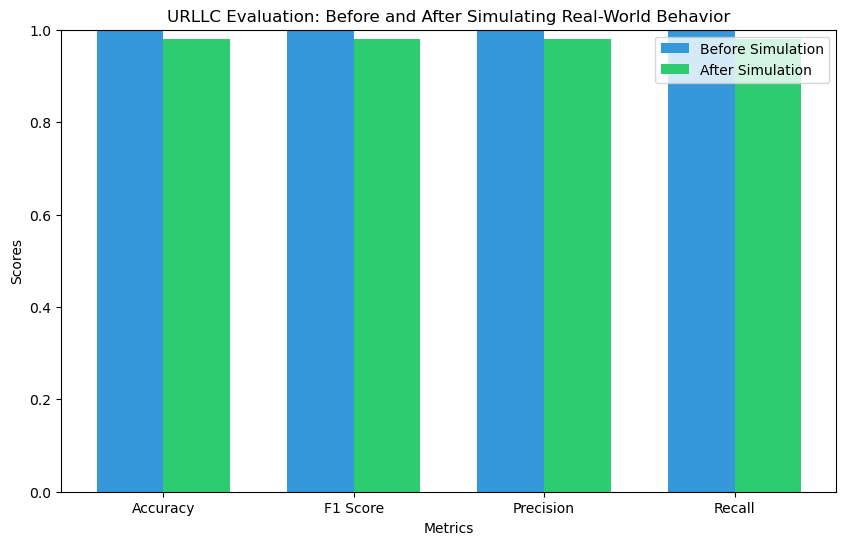

In [112]:
# Function to plot comparison of evaluation metrics before and after simulation
def plot_comparison_results(slice_name, before_accuracy, before_f1_score, before_precision, before_recall, after_accuracy, after_f1_score, after_precision, after_recall):
    categories = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
    
    # Values before and after simulating real-world behavior
    before_values = [before_accuracy, before_f1_score, before_precision, before_recall]
    after_values = [after_accuracy, after_f1_score, after_precision, after_recall]
    
    # X positions for the bars
    x = np.arange(len(categories))
    width = 0.35  # Width of the bars
    
    # Create subplots for comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot bars before and after simulation
    ax.bar(x - width/2, before_values, width, label='Before Simulation', color='#3498db')
    ax.bar(x + width/2, after_values, width, label='After Simulation', color='#2ecc71')
    
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title(f'{slice_name} Evaluation: Before and After Simulating Real-World Behavior')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()
    
    # Show the plot
    plt.ylim([0, 1])
    plt.show()

# Function to evaluate the model on original (raw) test data and on simulated (noisy) data
def compare_models_performance(model, x_test, y_test, slice_name, variability=0.1):
    # Simulate real-world behavior on the test data
    simulated_x_test = simulate_real_world_behavior(x_test, variability)
    
    # Get predictions before and after simulation
    predictions_before = model.predict(x_test)
    predictions_after = model.predict(simulated_x_test)
    
    # Metrics for original (before simulation) data
    accuracy_before = accuracy_score(y_test, predictions_before)
    f1_before = f1_score(y_test, predictions_before, average='weighted')
    class_report_before = classification_report(y_test, predictions_before, output_dict=True)
    precision_before = class_report_before['weighted avg']['precision']
    recall_before = class_report_before['weighted avg']['recall']
    
    # Metrics for simulated (after adding noise) data
    accuracy_after = accuracy_score(y_test, predictions_after)
    f1_after = f1_score(y_test, predictions_after, average='weighted')
    class_report_after = classification_report(y_test, predictions_after, output_dict=True)
    precision_after = class_report_after['weighted avg']['precision']
    recall_after = class_report_after['weighted avg']['recall']
    
    # Plot the comparison of results before and after simulation
    plot_comparison_results(slice_name, accuracy_before, f1_before, precision_before, recall_before, accuracy_after, f1_after, precision_after, recall_after)

# Compare models' performance for each slice: eMBB, mMTC, and URLLC
compare_models_performance(embb_model, embb_x_test, embb_y_test, 'eMBB', variability=0.2)
compare_models_performance(mmtc_model, mmtc_x_test, mmtc_y_test, 'mMTC', variability=0.15)
compare_models_performance(urllc_model, urllc_x_test, urllc_y_test, 'URLLC', variability=0.05)


# Detecting and Handling Anomalies



In [113]:
def detect_anomalies(features, contamination=0.01):
    detector = IsolationForest(contamination=contamination, random_state=42)
    anomaly_labels = detector.fit_predict(features)
    return anomaly_labels

# Detect anomalies in simulated datasets
embb_anomalies = detect_anomalies(simulated_embb_x_test)
mmtc_anomalies = detect_anomalies(simulated_mmtc_x_test)
urllc_anomalies = detect_anomalies(simulated_urllc_x_test)

# Count anomalies
print("\nAnomalies Detected:")
print(f"eMBB Anomalies: {np.sum(embb_anomalies == -1)}")
print(f"mMTC Anomalies: {np.sum(mmtc_anomalies == -1)}")
print(f"URLLC Anomalies: {np.sum(urllc_anomalies == -1)}")

# Enhance predictions by excluding anomalies
def remove_anomalies(features, labels, anomalies):
    mask = anomalies == 1  # Keep only normal data
    return features[mask], labels[mask]

# Clean datasets
clean_embb_x_test, clean_embb_y_test = remove_anomalies(simulated_embb_x_test, embb_y_test, embb_anomalies)
clean_mmtc_x_test, clean_mmtc_y_test = remove_anomalies(simulated_mmtc_x_test, mmtc_y_test, mmtc_anomalies)
clean_urllc_x_test, clean_urllc_y_test = remove_anomalies(simulated_urllc_x_test, urllc_y_test, urllc_anomalies)

# Predict and evaluate on cleaned data
print("\nEvaluations After Removing Anomalies:")
print("\nCleaned eMBB Evaluation:")
evaluate_model(clean_embb_y_test, predict_resources(embb_model, clean_embb_x_test))

print("\nCleaned mMTC Evaluation:")
evaluate_model(clean_mmtc_y_test, predict_resources(mmtc_model, clean_mmtc_x_test))

print("\nCleaned URLLC Evaluation:")
evaluate_model(clean_urllc_y_test, predict_resources(urllc_model, clean_urllc_x_test))


Anomalies Detected:
eMBB Anomalies: 12
mMTC Anomalies: 10
URLLC Anomalies: 9

Evaluations After Removing Anomalies:

Cleaned eMBB Evaluation:
Accuracy: 0.88
F1 Score: 0.8778868274582561
Classification Report:
               precision    recall  f1-score   support

       False       0.81      1.00      0.90       593
        True       1.00      0.76      0.86       557

    accuracy                           0.88      1150
   macro avg       0.90      0.88      0.88      1150
weighted avg       0.90      0.88      0.88      1150


Cleaned mMTC Evaluation:
Accuracy: 0.7502738225629791
F1 Score: 0.7248757382778438
Classification Report:
               precision    recall  f1-score   support

       False       0.69      1.00      0.82       507
        True       0.99      0.44      0.61       406

    accuracy                           0.75       913
   macro avg       0.84      0.72      0.71       913
weighted avg       0.83      0.75      0.72       913


Cleaned URLLC Evaluation:


# Visualizing Evaluation Results: Before and After Anomaly Removal

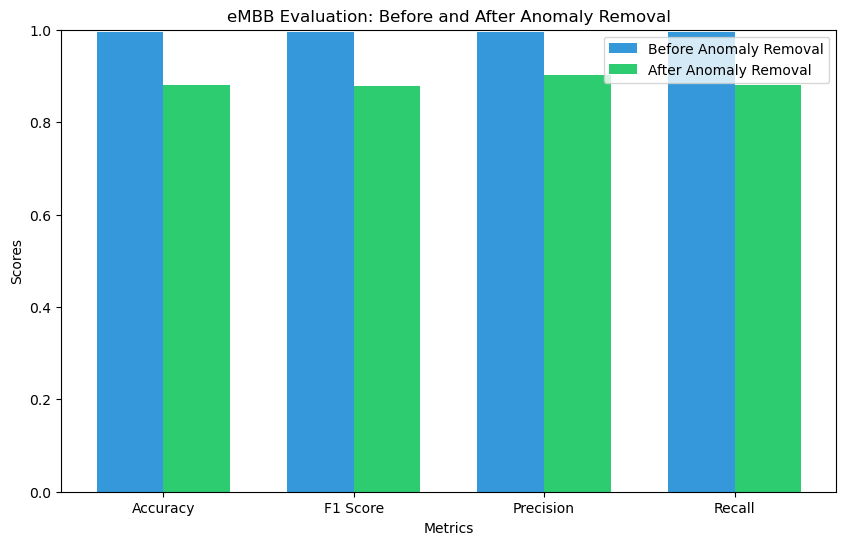

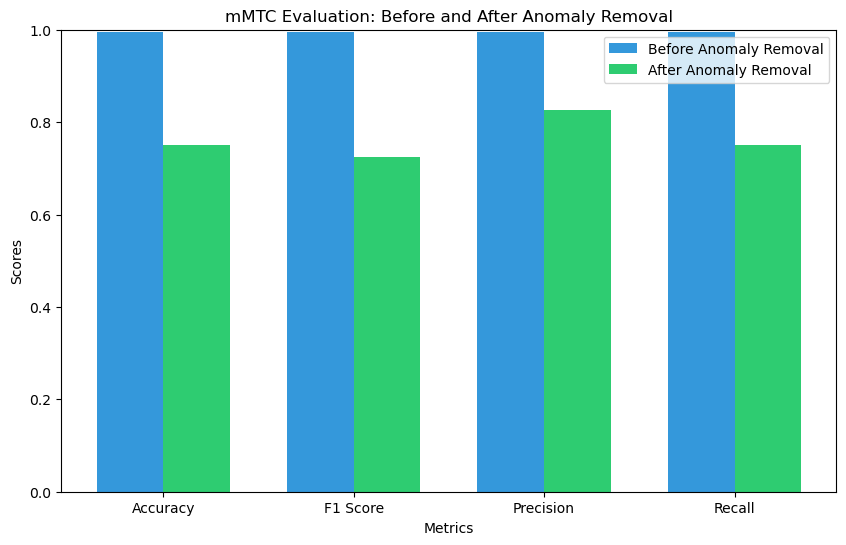

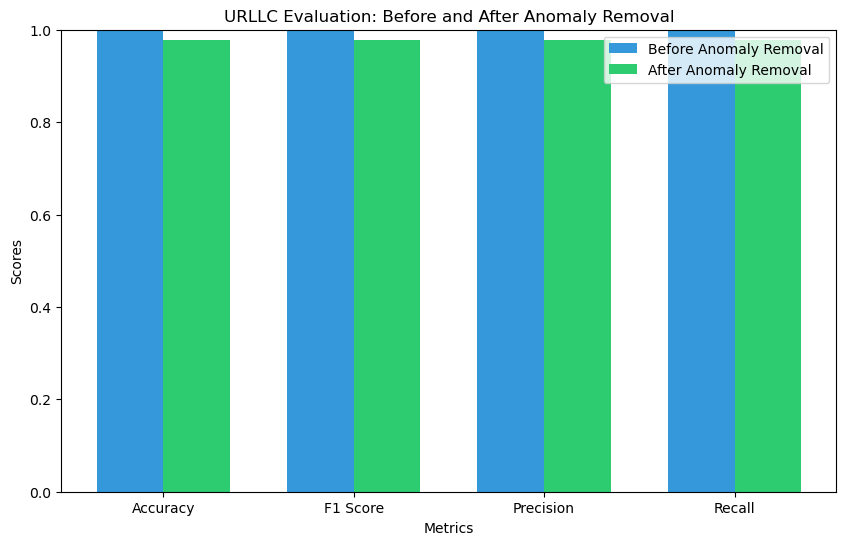

In [114]:

# Function to visualize evaluation results before and after removing anomalies
def plot_evaluation_results_comparison(slice_name, before_accuracy, before_f1_score, before_precision, before_recall, after_accuracy, after_f1_score, after_precision, after_recall):
    categories = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
    
    # Values before and after removing anomalies
    before_values = [before_accuracy, before_f1_score, before_precision, before_recall]
    after_values = [after_accuracy, after_f1_score, after_precision, after_recall]
    
    # X positions for the bars
    x = np.arange(len(categories))
    width = 0.35  # Width of the bars
    
    # Create subplots for comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot bars before and after anomalies removal
    ax.bar(x - width/2, before_values, width, label='Before Anomaly Removal', color='#3498db')
    ax.bar(x + width/2, after_values, width, label='After Anomaly Removal', color='#2ecc71')
    
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title(f'{slice_name} Evaluation: Before and After Anomaly Removal')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()

    # Show the plot
    plt.ylim([0, 1])
    plt.show()

# eMBB Evaluation Results Before and After Anomaly Removal
eMBB_before_accuracy = accuracy_score(embb_y_test, embb_predictions)
eMBB_before_f1_score = f1_score(embb_y_test, embb_predictions, average='weighted')
eMBB_class_report = classification_report(embb_y_test, embb_predictions, output_dict=True)
eMBB_before_precision = eMBB_class_report['weighted avg']['precision']
eMBB_before_recall = eMBB_class_report['weighted avg']['recall']

eMBB_after_accuracy = accuracy_score(clean_embb_y_test, predict_resources(embb_model, clean_embb_x_test))
eMBB_after_f1_score = f1_score(clean_embb_y_test, predict_resources(embb_model, clean_embb_x_test), average='weighted')
eMBB_class_report_cleaned = classification_report(clean_embb_y_test, predict_resources(embb_model, clean_embb_x_test), output_dict=True)
eMBB_after_precision = eMBB_class_report_cleaned['weighted avg']['precision']
eMBB_after_recall = eMBB_class_report_cleaned['weighted avg']['recall']

# mMTC Evaluation Results Before and After Anomaly Removal
mMTC_before_accuracy = accuracy_score(mmtc_y_test, mmtc_predictions)
mMTC_before_f1_score = f1_score(mmtc_y_test, mmtc_predictions, average='weighted')
mMTC_class_report = classification_report(mmtc_y_test, mmtc_predictions, output_dict=True)
mMTC_before_precision = mMTC_class_report['weighted avg']['precision']
mMTC_before_recall = mMTC_class_report['weighted avg']['recall']

mMTC_after_accuracy = accuracy_score(clean_mmtc_y_test, predict_resources(mmtc_model, clean_mmtc_x_test))
mMTC_after_f1_score = f1_score(clean_mmtc_y_test, predict_resources(mmtc_model, clean_mmtc_x_test), average='weighted')
mMTC_class_report_cleaned = classification_report(clean_mmtc_y_test, predict_resources(mmtc_model, clean_mmtc_x_test), output_dict=True)
mMTC_after_precision = mMTC_class_report_cleaned['weighted avg']['precision']
mMTC_after_recall = mMTC_class_report_cleaned['weighted avg']['recall']

# URLLC Evaluation Results Before and After Anomaly Removal
URLLC_before_accuracy = accuracy_score(urllc_y_test, urllc_predictions)
URLLC_before_f1_score = f1_score(urllc_y_test, urllc_predictions, average='weighted')
URLLC_class_report = classification_report(urllc_y_test, urllc_predictions, output_dict=True)
URLLC_before_precision = URLLC_class_report['weighted avg']['precision']
URLLC_before_recall = URLLC_class_report['weighted avg']['recall']

URLLC_after_accuracy = accuracy_score(clean_urllc_y_test, predict_resources(urllc_model, clean_urllc_x_test))
URLLC_after_f1_score = f1_score(clean_urllc_y_test, predict_resources(urllc_model, clean_urllc_x_test), average='weighted')
URLLC_class_report_cleaned = classification_report(clean_urllc_y_test, predict_resources(urllc_model, clean_urllc_x_test), output_dict=True)
URLLC_after_precision = URLLC_class_report_cleaned['weighted avg']['precision']
URLLC_after_recall = URLLC_class_report_cleaned['weighted avg']['recall']

# Visualize the results for each slice before and after anomaly removal
plot_evaluation_results_comparison('eMBB', eMBB_before_accuracy, eMBB_before_f1_score, eMBB_before_precision, eMBB_before_recall, eMBB_after_accuracy, eMBB_after_f1_score, eMBB_after_precision, eMBB_after_recall)
plot_evaluation_results_comparison('mMTC', mMTC_before_accuracy, mMTC_before_f1_score, mMTC_before_precision, mMTC_before_recall, mMTC_after_accuracy, mMTC_after_f1_score, mMTC_after_precision, mMTC_after_recall)
plot_evaluation_results_comparison('URLLC', URLLC_before_accuracy, URLLC_before_f1_score, URLLC_before_precision, URLLC_before_recall, URLLC_after_accuracy, URLLC_after_f1_score, URLLC_after_precision, URLLC_after_recall)


# Measuring Performance Metrics


In [115]:
def measure_performance(predictions, slice_type):
    slice_metrics = {
        'eMBB': {'base_throughput': 100, 'base_latency': 30, 'base_utilization': 70},
        'mMTC': {'base_throughput': 50, 'base_latency': 100, 'base_utilization': 50},
        'URLLC': {'base_throughput': 200, 'base_latency': 1, 'base_utilization': 90},
    }
    
    metrics = slice_metrics[slice_type]
    throughput = metrics['base_throughput'] * (1 + 0.01 * len(predictions))
    latency = metrics['base_latency'] / (1 + 0.01 * len(predictions))
    utilization = min(100, metrics['base_utilization'] + 0.1 * np.sum(predictions))
    
    return {
        'Throughput (Mbps)': throughput,
        'Latency (ms)': latency,
        'Resource Utilization (%)': utilization
    }

# Example for all slices:
embb_performance = measure_performance(embb_predictions, 'eMBB')
mmtc_performance = measure_performance(mmtc_predictions, 'mMTC')
urllc_performance = measure_performance(urllc_predictions, 'URLLC')

print(f"eMBB Performance: {embb_performance}")
print(f"mMTC Performance: {mmtc_performance}")
print(f"URLLC Performance: {urllc_performance}")


eMBB Performance: {'Throughput (Mbps)': 1262.0, 'Latency (ms)': 2.3771790808240887, 'Resource Utilization (%)': 100}
mMTC Performance: {'Throughput (Mbps)': 511.5, 'Latency (ms)': 9.775171065493646, 'Resource Utilization (%)': 90.80000000000001}
URLLC Performance: {'Throughput (Mbps)': 1814.0, 'Latency (ms)': 0.11025358324145534, 'Resource Utilization (%)': 100}


# Visulaising Performance Metrics

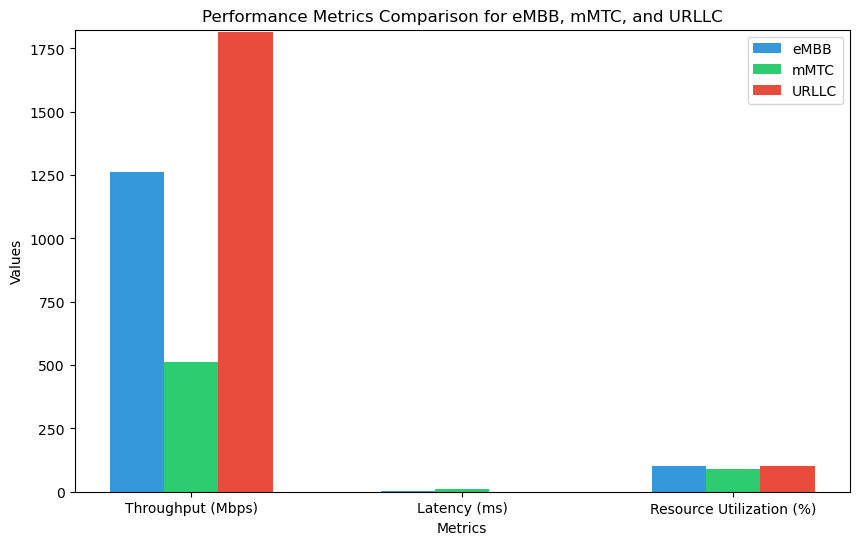

In [116]:
def plot_performance_metrics(embb_performance, mmtc_performance, urllc_performance):
    categories = ['Throughput (Mbps)', 'Latency (ms)', 'Resource Utilization (%)']
    
    # Values for each slice type
    embb_values = list(embb_performance.values())
    mmtc_values = list(mmtc_performance.values())
    urllc_values = list(urllc_performance.values())
    
    # X positions for the bars
    x = np.arange(len(categories))
    width = 0.2  # Width of the bars
    
    # Create subplots for comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot bars for each slice type
    ax.bar(x - width, embb_values, width, label='eMBB', color='#3498db')
    ax.bar(x, mmtc_values, width, label='mMTC', color='#2ecc71')
    ax.bar(x + width, urllc_values, width, label='URLLC', color='#e74c3c')
    
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title('Performance Metrics Comparison for eMBB, mMTC, and URLLC')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()

    # Show the plot
    plt.ylim([0, max(max(embb_values), max(mmtc_values), max(urllc_values)) + 10])  # Adjust the y-axis to fit all data
    plt.show()

# Example performance data for all slices:
embb_performance = measure_performance(embb_predictions, 'eMBB')
mmtc_performance = measure_performance(mmtc_predictions, 'mMTC')
urllc_performance = measure_performance(urllc_predictions, 'URLLC')

# Visualize the results
plot_performance_metrics(embb_performance, mmtc_performance, urllc_performance)


# Measuring Security Metrics


In [117]:
def simulate_security_metrics(predictions, slice_type, anomalies):
    base_response_time = {'eMBB': 0.5, 'mMTC': 1.0, 'URLLC': 0.1}
    base_incident_rate = {'eMBB': 2, 'mMTC': 1, 'URLLC': 0}
    
    num_anomalies = np.sum(anomalies == -1)
    response_time = base_response_time[slice_type] * (1 + 0.1 * num_anomalies)
    incident_rate = base_incident_rate[slice_type] + num_anomalies
    impact_on_performance = max(0, 100 - 10 * num_anomalies)
    
    return {
        'Security Incident Rate': incident_rate,
        'Response Time (s)': response_time,
        'Impact on Performance (%)': impact_on_performance
    }

# Example for all slices:
embb_security = simulate_security_metrics(embb_predictions, 'eMBB', embb_anomalies)
mmtc_security = simulate_security_metrics(mmtc_predictions, 'mMTC', mmtc_anomalies)
urllc_security = simulate_security_metrics(urllc_predictions, 'URLLC', urllc_anomalies)

print(f"eMBB Security: {embb_security}")
print(f"mMTC Security: {mmtc_security}")
print(f"URLLC Security: {urllc_security}")


eMBB Security: {'Security Incident Rate': 14, 'Response Time (s)': 1.1, 'Impact on Performance (%)': 0}
mMTC Security: {'Security Incident Rate': 11, 'Response Time (s)': 2.0, 'Impact on Performance (%)': 0}
URLLC Security: {'Security Incident Rate': 9, 'Response Time (s)': 0.19, 'Impact on Performance (%)': 10}


# Visualising Security Metrics

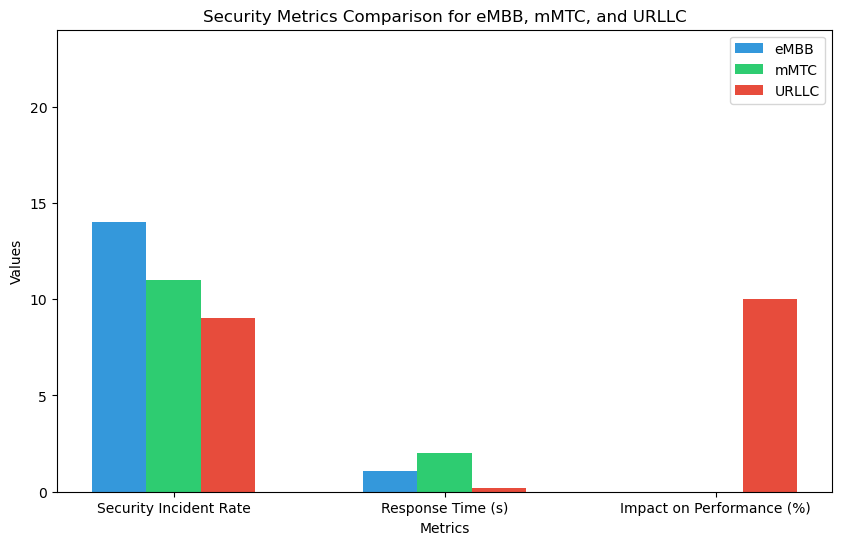

In [118]:
# Function to visualize security metrics
def plot_security_metrics(embb_security, mmtc_security, urllc_security):
    categories = ['Security Incident Rate', 'Response Time (s)', 'Impact on Performance (%)']
    
    # Values for each slice type
    embb_values = list(embb_security.values())
    mmtc_values = list(mmtc_security.values())
    urllc_values = list(urllc_security.values())
    
    # X positions for the bars
    x = np.arange(len(categories))
    width = 0.2  # Width of the bars
    
    # Create subplots for comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot bars for each slice type
    ax.bar(x - width, embb_values, width, label='eMBB', color='#3498db')
    ax.bar(x, mmtc_values, width, label='mMTC', color='#2ecc71')
    ax.bar(x + width, urllc_values, width, label='URLLC', color='#e74c3c')
    
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title('Security Metrics Comparison for eMBB, mMTC, and URLLC')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()
    
    # Show the plot
    plt.ylim([0, max(max(embb_values), max(mmtc_values), max(urllc_values)) + 10])  # Adjust y-axis to fit data
    plt.show()

# Example security data for all slices:
embb_security = simulate_security_metrics(embb_predictions, 'eMBB', embb_anomalies)
mmtc_security = simulate_security_metrics(mmtc_predictions, 'mMTC', mmtc_anomalies)
urllc_security = simulate_security_metrics(urllc_predictions, 'URLLC', urllc_anomalies)

# Visualize the results
plot_security_metrics(embb_security, mmtc_security, urllc_security)


# Evaluating Resource Allocations


In [119]:
def allocate_resources(predictions, slice_type):
    resources = {"CPU": 0, "Bandwidth": 0, "Storage": 0}
    for pred in predictions:
        if slice_type == 'eMBB':
            resources["CPU"] += 2 * pred
            resources["Bandwidth"] += 3 * pred
        elif slice_type == 'mMTC':
            resources["CPU"] += 1 * pred
            resources["Storage"] += 2 * pred
        elif slice_type == 'URLLC':
            resources["CPU"] += 3 * pred
            resources["Bandwidth"] += 1 * pred
    return resources

# Example for all slices:
print("eMBB Resources:", allocate_resources(embb_predictions, 'eMBB'))
print("mMTC Resources:", allocate_resources(mmtc_predictions, 'mMTC'))
print("URLLC Resources:", allocate_resources(urllc_predictions, 'URLLC'))


eMBB Resources: {'CPU': 1104, 'Bandwidth': 1656, 'Storage': 0}
mMTC Resources: {'CPU': 408, 'Bandwidth': 0, 'Storage': 816}
URLLC Resources: {'CPU': 1413, 'Bandwidth': 471, 'Storage': 0}


# Visualising Resource Allocations

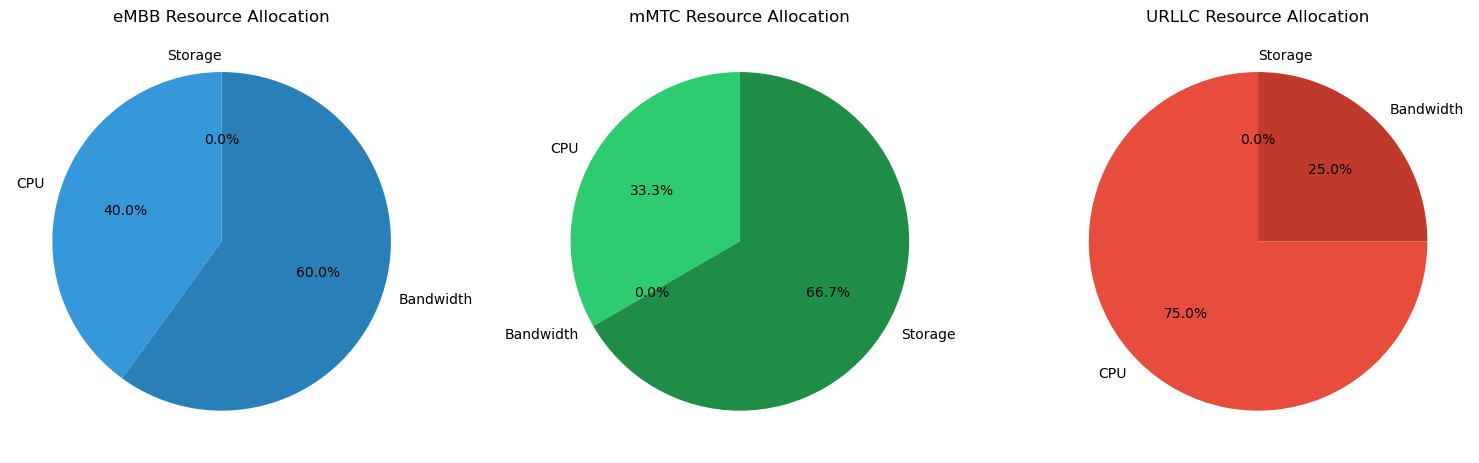

In [126]:
def plot_resource_allocation_pie(embb_resources, mmtc_resources, urllc_resources):
    categories = ['CPU', 'Bandwidth', 'Storage']
    
    # Resource allocation values for each slice
    embb_values = list(embb_resources.values())
    mmtc_values = list(mmtc_resources.values())
    urllc_values = list(urllc_resources.values())
    
    # Create subplots for comparison
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))

    # Plot pie charts for each slice type
    ax[0].pie(embb_values, labels=categories, autopct='%1.1f%%', startangle=90, colors=['#3498db', '#2980b9', '#1f6394'])
    ax[0].set_title('eMBB Resource Allocation')

    ax[1].pie(mmtc_values, labels=categories, autopct='%1.1f%%', startangle=90, colors=['#2ecc71', '#27ae60', '#1f8c47'])
    ax[1].set_title('mMTC Resource Allocation')

    ax[2].pie(urllc_values, labels=categories, autopct='%1.1f%%', startangle=90, colors=['#e74c3c', '#c0392b', '#9b2c1f'])
    ax[2].set_title('URLLC Resource Allocation')

    # Display the plot
    plt.tight_layout()
    plt.show()

# Example resource allocation for all slices:
embb_resources = allocate_resources(embb_predictions, 'eMBB')
mmtc_resources = allocate_resources(mmtc_predictions, 'mMTC')
urllc_resources = allocate_resources(urllc_predictions, 'URLLC')

# Visualize the resource allocation as pie charts
plot_resource_allocation_pie(embb_resources, mmtc_resources, urllc_resources)


# Visualizing Measurements


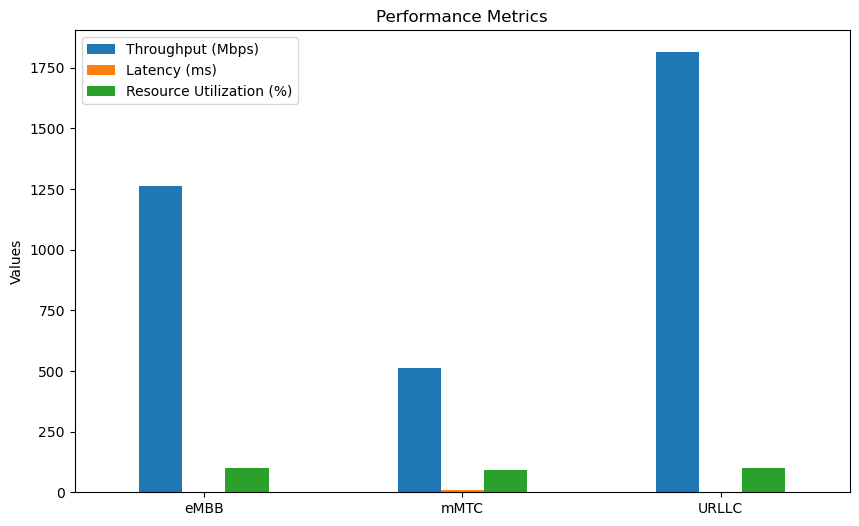

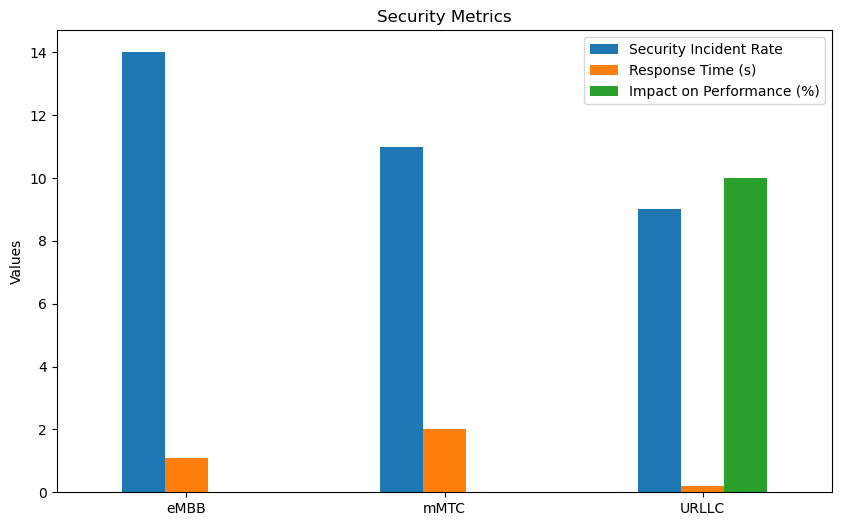

In [121]:
# Performance Visualization
performance_data = pd.DataFrame([embb_performance, mmtc_performance, urllc_performance], index=['eMBB', 'mMTC', 'URLLC'])
performance_data.plot(kind='bar', figsize=(10, 6), title="Performance Metrics", rot=0)
plt.ylabel("Values")
plt.show()

# Security Visualization
security_data = pd.DataFrame([embb_security, mmtc_security, urllc_security], index=['eMBB', 'mMTC', 'URLLC'])
security_data.plot(kind='bar', figsize=(10, 6), title="Security Metrics", rot=0)
plt.ylabel("Values")
plt.show()
